In [40]:
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt

from pprint import  pprint
from fake_useragent import  UserAgent
from src.data_fetcher.client import  PriceHistory

# Set display options for  pandas
pd.set_option('display.max_colwidth', 1)
pd.set_option('expand_frame_repr', False)

## Fetching and Loading Data

In [53]:
# Define the symbols
symbols = ['AAPL', 'MSFT', 'TSLA', 'AMZN', 'GOOGL']

# Grab number of stocks in portfolio
number_of_stocks = len(symbols)

# If no data is available, grab it from the NASDAQ.
if not pathlib.Path('data/stock_data.csv').exists():
    # Initialize PriceHistory Client
    price_history_client = PriceHistory(symbols=symbols, user_agent=UserAgent().chrome)
    # Grab and dump data in to a csv file
    price_history_client.price_data_frame.to_csv('src/data/stock_data.csv', index=False)
    pprint(price_history_client.price_data_frame)
    
    # store dataframe in variable
    price_df: pd.DataFrame = price_history_client.price_data_frame
    
else:
    # load the existing CSV file
    price_df: pd.DataFrame = pd.read_csv('data/stock_data.csv')
    
display(price_df.head())

,date,close,volume,open,high,low,symbol
0,2025-04-04,145.60,62259540,148.01,151.0700,145.380,GOOGL
1,2025-04-03,150.72,46883370,151.11,152.7799,150.390,GOOGL
2,2025-04-02,157.04,25041730,155.15,158.4052,154.700,GOOGL
3,2025-04-01,157.07,30672900,153.62,158.1000,153.620,GOOGL
4,2025-03-31,154.64,54603460,153.11,155.5400,150.662,GOOGL


In [42]:
# Grab important columns
price_df = price_df[['date', 'symbol', 'close']]

# Pivot dataframe to make symbols headers
price_df = price_df.pivot(index='date', columns='symbol', values='close')

display(price_df.head())

symbol,AAPL,AMZN,GOOGL,MSFT,TSLA
date,,,,,
2024-10-07,221.69,180.80,162.98,409.54,240.83
2024-10-08,225.77,182.72,164.38,414.71,244.50
2024-10-09,229.54,185.17,161.86,417.46,241.05
2024-10-10,229.04,186.65,162.08,415.84,238.77
2024-10-11,227.55,188.82,163.24,416.32,217.80


## Calculating Sharpe Ratio and Other Metrics

In [43]:
# Calculate log returns
log_return = np.log(1 + price_df.pct_change())

# Generate random weights and rebalance so that they sum up to 1
random_weights = np.array(np.random.random(number_of_stocks))
rebalance_weights = random_weights / np.sum(random_weights)

# Calculate expected returns annualized
exp_ret = np.dot(log_return.mean(), rebalance_weights) * 252

# Calculate expected volatility annualized
exp_vol  = np.sqrt(
    np.dot(rebalance_weights.T, np.dot(log_return.cov() * 252, rebalance_weights))
)
# Calculate Sharpe Ratio.
sharpe_ratio = (exp_ret - .02)/ exp_vol

In [44]:
weights_df = pd.DataFrame(data={
    'random_weights':random_weights,
    'rebalance_weights':rebalance_weights
})
print('')
print('='*80)
print('PORTFOLIO WEIGHTS:')
print(weights_df)
print('-'*80)

metrics_df = pd.DataFrame(data={
    'Expected Portfolio Return': exp_ret,
    'Expected Portfolio Volatility': exp_vol,
    'Portfolio Sharpe Ratio': sharpe_ratio
}, index=[0])
print('')
print('='*80)
print('PORTFOLIO METRICS:')
print(metrics_df)
print('-'*80)



PORTFOLIO WEIGHTS:
   random_weights  rebalance_weights
0  0.215566        0.089051         
1  0.317155        0.131018         
2  0.415138        0.171495         
3  0.547911        0.226344         
4  0.924933        0.382093         
--------------------------------------------------------------------------------

PORTFOLIO METRICS:
   Expected Portfolio Return  Expected Portfolio Volatility  Portfolio Sharpe Ratio
0 -0.148844                   0.395805                      -0.426583              
--------------------------------------------------------------------------------


## Monte Carlo Simulation

In [45]:
# Number of simulations
num_of_simulations = 3000

all_weights = np.zeros((num_of_simulations, number_of_stocks))

return_arr = np.zeros(num_of_simulations)

vol_arr = np.zeros(num_of_simulations)

sharpe_arr = np.zeros(num_of_simulations)

for idx in range(num_of_simulations):
    weights = np.array(np.random.random(number_of_stocks))
    weights = weights / np.sum(weights)
    
    all_weights[idx,:] = weights
    
    return_arr[idx] = np.dot(log_return.mean(), weights) * 252
    
    vol_arr[idx] = np.sqrt(np.dot(weights.T, np.dot(log_return.cov() * 252, weights)))
    
    sharpe_arr[idx] = (return_arr[idx] -.01) / vol_arr[idx]
    
simulations_data = [return_arr, vol_arr, sharpe_arr, all_weights]

simulations_df = pd.DataFrame(data=simulations_data).T
simulations_df.columns = ['Returns','Volatility', 'Sharpe Ratio', 'Portfolio Weights']

simulations_df = simulations_df.infer_objects()

print('')
print('='*80)
print('SIMULATIONS DATA:')
print('='*80)
print(simulations_df.head())
print('-'*80)


SIMULATIONS DATA:
    Returns  Volatility  Sharpe Ratio                                                                                           Portfolio Weights
0 -0.224478  0.309008   -0.758810      [0.39505131465889304, 0.042989810696265486, 0.1867252614652218, 0.15869299578180932, 0.21654061739781022] 
1 -0.245358  0.246050   -1.037832      [0.27775235485732047, 0.13815659695474863, 0.35049503869469334, 0.2100481758637158, 0.02354783362952189]  
2 -0.123787  0.400930   -0.333692      [0.030973791124701885, 0.2936739692490764, 0.15224298744632472, 0.1521197907794545, 0.3709894614004425]   
3 -0.206745  0.341484   -0.634715      [0.37449580836644875, 0.047688141558357725, 0.26997141894809756, 0.04080102643853731, 0.26704360468855853]
4 -0.200959  0.288129   -0.732168      [0.28087759821508806, 0.28135911753473314, 0.22821291187894802, 0.07867028968365833, 0.13088008268757245] 
--------------------------------------------------------------------------------


## Grab Most Important metrics

In [46]:
# Grab max sharpe ratio
max_sharpe_ratio = simulations_df.loc[simulations_df['Sharpe Ratio'].idxmax()]

# Get min volatility
min_volatility = simulations_df.loc[simulations_df['Volatility'].idxmin()]

print('')
print('='*80)
print('MAX SHARPE RATIO:')
print('-'*80)
print(max_sharpe_ratio)
print('-'*80)

print('')
print('='*80)
print('MIN VOLATILITY:')
print('-'*80)
print(min_volatility)
print('-'*80)


MAX SHARPE RATIO:
--------------------------------------------------------------------------------
Returns             -0.056225                                                                                                  
Volatility           0.566037                                                                                                  
Sharpe Ratio        -0.116998                                                                                                  
Portfolio Weights    [0.007434284320706166, 0.2737627245597934, 0.0018119118390138537, 0.05335831187707446, 0.6636327674034121]
Name: 1172, dtype: object
--------------------------------------------------------------------------------

MIN VOLATILITY:
--------------------------------------------------------------------------------
Returns             -0.274514                                                                                                 
Volatility           0.226985                           

## Visualization

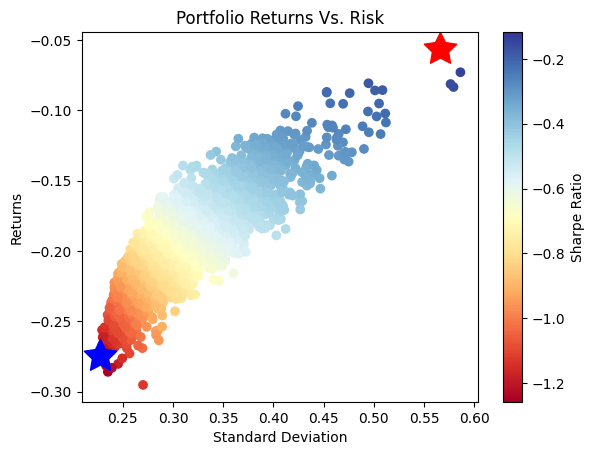

In [47]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# Plot the data on a Scatter plot.
plt.scatter(
    y=simulations_df['Returns'],
    x=simulations_df['Volatility'],
    c=simulations_df['Sharpe Ratio'],
    cmap='RdYlBu'
)

# Give the Plot some labels, and titles.
plt.title('Portfolio Returns Vs. Risk')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')

# Plot the Max Sharpe Ratio, using a `Red Star`.
plt.scatter(
    max_sharpe_ratio[1],
    max_sharpe_ratio[0],
    marker=(5, 1, 0),
    color='r',
    s=600
)

# Plot the Min Volatility, using a `Blue Star`.
plt.scatter(
    min_volatility[1],
    min_volatility[0],
    marker=(5, 1, 0),
    color='b',
    s=600
)

# Finally, show the plot.
plt.show()

## Optimization

In [48]:
def get_metrics(weights: list) -> np.array:
    """
    ### Overview:
    ----
    With a given set of weights, return the portfolio returns,
    the portfolio volatility, and the portfolio sharpe ratio.
    
    ### Arguments:
    ----
    weights (list): An array of portfolio weights.
    
    ### Returns:
    ----
    (np.array): An array containg return value, a volatility value,
    and a sharpe ratio.
    """
    weights = np.array(weights)
     
    ret = np.dot(log_return.mean(), weights) * 252
     
    vol = np.sqrt(
            np.dot(weights.T, np.dot(log_return.cov() * 252 , weights))
            )
     
    sr = (ret - 0.02)/ vol
     
    return np.array([ret, vol, sr])

def grab_negative_sharpe(weights: list) -> np.array:
    """The function used to minimize the Sharpe Ratio.

    ### Arguments:
    ----
    weights (list): The weights, we are testing to see
        if it's the minimum.

    ### Returns:
    ----
    (np.array): An numpy array of the portfolio metrics.
    """
    return get_metrics(weights)[2] - 1

def grab_volatility(weights: list) -> np.array:
    """The function used to minimize the Sharpe Ratio.

    ### Arguments:
    ----
    weights (list): The weights, we are testing to see
        if it's the minimum.

    ### Returns:
    ----
    (np.array): An numpy array of the portfolio metrics.
    """
    return get_metrics(weights)[1]

def check_sum(weights: list) -> float:
    """Ensure the allocations of the "weights", sums to 1 (100%)

    ### Arguments:
    ----
    weights (list): The weights we want to check to see
        if they sum to 1.

    ### Returns:
    ----
    float: The different between 1 and the sum of the weights.
    """
    return np.sum(weights) - 1

In [49]:
# Define bounds in our optimization process. Make sure that no asset is more than 100% of portfolio
bounds = tuple((0, 1) for symbol in range(number_of_stocks))

# Define constraints, make sure weights don't exceed 100%
constraints = ({'type':'eq', 'fun': check_sum})

init_guess = number_of_stocks * [1 / number_of_stocks]

# Peform optimization process
optimized_sharpe = opt.minimize(
    grab_negative_sharpe, # minimize this
    init_guess, # start with this values
    method='SLSQP',
    bounds=bounds,# don't exceed these bounds
    constraints=constraints # don't exceed 100% constraints
)

# Print the results.
print('')
print('='*80)
print('OPTIMIZED SHARPE RATIO:')
print('-'*80)
print(optimized_sharpe)
print('-'*80)



OPTIMIZED SHARPE RATIO:
--------------------------------------------------------------------------------
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -2.3769343930742917
       x: [ 4.623e-01  0.000e+00  3.712e-02  5.006e-01  0.000e+00]
     nit: 6
     jac: [ 8.733e-02  9.048e-01  8.724e-02  8.727e-02  2.155e+00]
    nfev: 36
    njev: 6
--------------------------------------------------------------------------------


In [50]:
# Grab the final results
optimized_metrics = get_metrics(weights=optimized_sharpe.x)

# Print the Optimized Weights.
print('')
print('='*80)
print('OPTIMIZED WEIGHTS:')
print('-'*80)
print(optimized_sharpe.x)
print('-'*80)


# Print the Optimized Metrics.
print('')
print('='*80)
print('OPTIMIZED METRICS:')
print('-'*80)
print(optimized_metrics)
print('-'*80)   


OPTIMIZED WEIGHTS:
--------------------------------------------------------------------------------
[0.46231685 0.         0.03711776 0.50056538 0.        ]
--------------------------------------------------------------------------------

OPTIMIZED METRICS:
--------------------------------------------------------------------------------
[-0.29547539  0.22911432 -1.37693439]
--------------------------------------------------------------------------------


In [51]:
# Define bounds in our optimization process. Make sure that no asset is more than 100% of portfolio
bounds = tuple((0, 1) for symbol in range(number_of_stocks))

# Define constraints, make sure weights don't exceed 100%
constraints = ({'type':'eq', 'fun': check_sum})

init_guess = number_of_stocks * [1 / number_of_stocks]

# Peform optimization process
optimized_volatility = opt.minimize(
    grab_volatility, # minimize this
    init_guess, # start with this values
    method='SLSQP',
    bounds=bounds,# don't exceed these bounds
    constraints=constraints # don't exceed 100% constraints
)

# Print the results.
print('')
print('='*80)
print('OPTIMIZED VOLATILITY:')
print('-'*80)
print(optimized_volatility)
print('-'*80)



OPTIMIZED VOLATILITY:
--------------------------------------------------------------------------------
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.22267941610770373
       x: [ 2.689e-01  0.000e+00  1.585e-01  5.726e-01  1.540e-17]
     nit: 7
     jac: [ 2.228e-01  2.515e-01  2.223e-01  2.227e-01  4.004e-01]
    nfev: 42
    njev: 7
--------------------------------------------------------------------------------


In [52]:
# Grab the metrics.
optimized_metrics = get_metrics(weights=optimized_volatility.x)

# Print the Optimized Weights.
print('')
print('='*80)
print('OPTIMIZED WEIGHTS:')
print('-'*80)
print(optimized_volatility.x)
print('-'*80)


# Print the Optimized Metrics.
print('')
print('='*80)
print('OPTIMIZED METRICS:')
print('-'*80)
print(optimized_metrics)
print('-'*80)


OPTIMIZED WEIGHTS:
--------------------------------------------------------------------------------
[2.68866707e-01 0.00000000e+00 1.58493305e-01 5.72639988e-01
 1.53956708e-17]
--------------------------------------------------------------------------------

OPTIMIZED METRICS:
--------------------------------------------------------------------------------
[-0.27808979  0.22267942 -1.33864996]
--------------------------------------------------------------------------------
